In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
from copy import deepcopy

In [3]:
sheet_name = 'Sheet1'
df = pd.read_excel("./compounds.xlsx", sheet_name = sheet_name)
# df = df.dropna(subset = ['chemical'])
# # df = df.dropna()
# df = df.dropna(subset = ['Isomeric SMILES', 'Canonical SMILES'], how = 'all')

In [4]:

weight = []
logp = []
h_bond_donor = []
h_bond_acceptors = []
for i, row in df.iterrows():

    if ((not isinstance(row['chem'], str)) or 
        (not isinstance(row.get('smile', None), str)) ):
        weight.append(None)
        logp.append(None)
        h_bond_donor.append(None)
        h_bond_acceptors.append(None)
        continue

    try:
        molecule = Chem.MolFromSmiles(row['smile'])

    except:
        molecule = Chem.MolFromSmiles(row['Isomeric SMILES'])
    weight.append(Descriptors.ExactMolWt(molecule))
    logp.append(Descriptors.MolLogP(molecule))
    h_bond_donor.append(Descriptors.NumHDonors(molecule))
    h_bond_acceptors.append(Descriptors.NumHAcceptors(molecule))

df['weight'] = weight
df['logp'] = logp
df['h_bond_donor'] = h_bond_donor
df['h_bond_acceptors'] = h_bond_acceptors

df['weight_pass'] = df['weight'] < 500
df['logp_pass'] = df['logp'] <5
df['h_bond_donor_pass'] = df['h_bond_donor'] < 5
df['h_bond_acceptors_pass'] = df['h_bond_acceptors'] < 10

df['weight_pass'][df['weight'].apply(np.isnan)] = None
df['logp_pass'][df['weight'].apply(np.isnan)] = None
df['h_bond_donor_pass'][df['weight'].apply(np.isnan)] = None
df['h_bond_acceptors_pass'][df['weight'].apply(np.isnan)] = None

df['summary'] =  df[['weight_pass', 'logp_pass', 'h_bond_donor_pass','h_bond_acceptors_pass']].sum(axis = 1)
df['summary'][df['weight'].apply(np.isnan)] = -1

C:\Users\dream\AppData\Local\Temp\ipykernel_9480\672696220.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['weight_pass'][df['weight'].apply(np.isnan)] = None
C:\Users\dream\AppData\Local\Temp\ipykernel_9480\672696220.py:35: SettingW

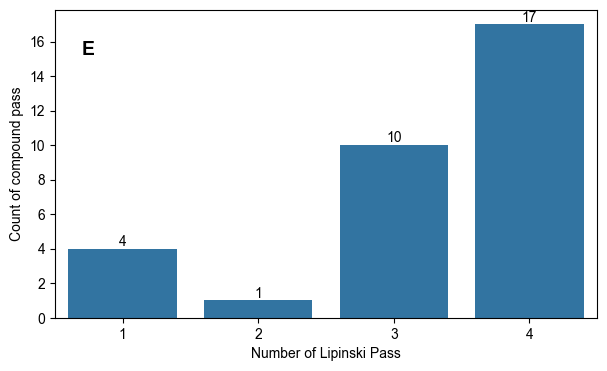

In [5]:
df_plot = deepcopy(df[df['summary']>0])
plt.figure(figsize=(7, 4))

ax = sns.barplot(
    x = df_plot['summary'].value_counts().keys(), 
    y = df_plot['summary'].value_counts().values)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel='Number of Lipinski Pass', ylabel='Count of compound pass')
ax.text(0.05, 0.90, 'E', transform=ax.transAxes,
                    fontsize=14, fontweight='bold', va='top', ha='left')
plt.savefig('E.png', dpi=800, bbox_inches='tight')

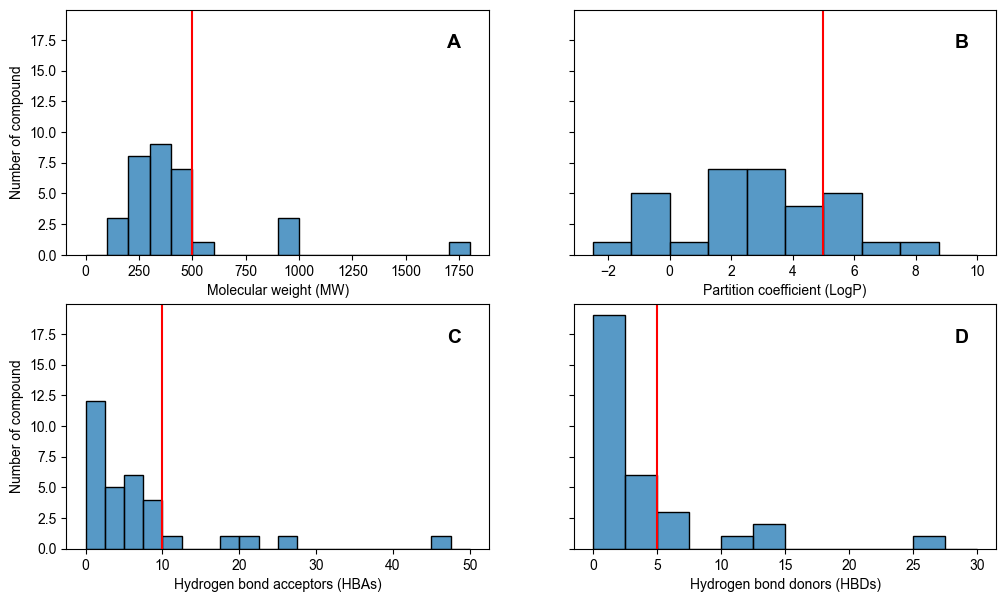

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharey=True)

# Bulbasaur
sns.histplot(df_plot['weight'], binwidth = 100, binrange=(0, 1800),ax = axes[0][0])
sns.histplot(df_plot['logp'], binwidth=1.25, binrange=(-2.5,10),ax = axes[0][1])
sns.histplot(df_plot["h_bond_acceptors"], binwidth=2.5, binrange=(0,50),ax = axes[1][0])
sns.histplot(df_plot["h_bond_donor"], binwidth=2.5, binrange=(0,30),ax = axes[1][1])

axes[0][0].set_xlabel("Molecular weight (MW)")
axes[0][1].set_xlabel("Partition coefficient (LogP)")
axes[1][0].set_xlabel("Hydrogen bond acceptors (HBAs)")
axes[1][1].set_xlabel("Hydrogen bond donors (HBDs)")

axes[0][0].set_ylabel("Number of compound")
axes[0][1].set_ylabel("Number of compound")
axes[1][0].set_ylabel("Number of compound")
axes[1][1].set_ylabel("Number of compound")

axes[0][0].axvline(x=500, color = 'r')
axes[0][1].axvline(x=5, color = 'r')
axes[1][0].axvline(x=10, color = 'r')
axes[1][1].axvline(x=5, color = 'r')

# Add subplot labels
labels = ['A', 'B', 'C', 'D']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
for label, (i, j) in zip(labels, positions):
    axes[i][j].text(0.9, 0.90, label, transform=axes[i][j].transAxes,
                    fontsize=14, fontweight='bold', va='top', ha='left')

plt.savefig('A-D.png', dpi=800, bbox_inches='tight')

In [9]:
import os
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image, ImageDraw, ImageFont
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from openpyxl.utils import get_column_letter

df_pass = df[df['summary'] == 4]
df_pass = df_pass.reset_index(drop=True)
# Create directory to store images

# Ensure picture folder exists
os.makedirs("picture", exist_ok=True)

# Excel workbook
wb = Workbook()
ws = wb.active
ws.title = "Molecule Structures"

# Headers: all df_pass columns + Structure column
headers = list(df_pass.columns) + ["Structure"]
ws.append(headers)

# Optional: You can set a font path here, otherwise default font is used
# font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
# font = ImageFont.truetype(font_path, 14)
font = ImageFont.truetype("C:/Windows/Fonts/arial.ttf", 14)

for idx, (i, row) in enumerate(df_pass.iterrows(), start=2):
    smiles = row['smile']
    mol = Chem.MolFromSmiles(smiles)

    # Create molecule image
    img = Draw.MolToImage(mol, size=(300, 300))

    # Convert to PIL Image to draw text
    img = img.convert("RGBA")
    draw = ImageDraw.Draw(img)

    # Compose and draw the text
    text = f"Scientific name: {row['plant']}"
    text_position = (10, 10)
    text_color = (0, 0, 0)  # black
    draw.text(text_position, text, fill=text_color, font=font)

    text = f"Compound name: {row['chem']}"
    text_position = (10, 20)
    text_color = (0, 0, 0)  # black
    draw.text(text_position, text, fill=text_color, font=font)

    # Save image with text
    img_path = f"picture/{i+2}.png"
    img.save(img_path)

    # Write all values to Excel
    for col_idx, value in enumerate(row, start=1):
        ws.cell(row=idx, column=col_idx, value=value)

    # Insert image into Excel
    img_col_idx = len(row) + 1
    img_col_letter = get_column_letter(img_col_idx)
    xl_img = XLImage(img_path)
    xl_img.width = 150
    xl_img.height = 120
    ws.add_image(xl_img, f"{img_col_letter}{idx}")

# Save the Excel workbook
wb.save("molecule_structures.xlsx")


In [14]:
import matplotlib.pyplot as plt
import math

# Parameters for the grid
n = len(df_pass)
cols = 4  # You can change this based on how wide you want it
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

for idx, (i, row) in enumerate(df_pass.iterrows()):
    smiles = row['smile']
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=(300, 310), dpi = 800)

    img = img.convert("RGBA")
    draw = ImageDraw.Draw(img)
    
    # Add labels
    if row['chem'].strip() in ['14-deoxy-11, 12-didehydroandrographolide', 'Tetrahydrocannabivarin (THCV)']:
        draw.text((10, 0), f"Scientific name: {row['plant']}", fill=(0, 0, 0), font=font)
        draw.text((10, 15), f"Compound:", fill=(0, 0, 0), font=font)
        draw.text((10, 30), f"{row['chem']}", fill=(0, 0, 0), font=font)
    # elif row['chem'].strip == 'Zerumbone':
    #     draw.text((10, 0), f"Scientific name: {row['plant']}", fill=(0, 0, 0), font=font)
    #     draw.text((10, 15), f"Compound:", fill=(0, 0, 0), font=font)
    else:
        draw.text((10, 0), f"Scientific name: {row['plant']}", fill=(0, 0, 0), font=font)
        draw.text((10, 15), f"Compound: {row['chem']}", fill=(0, 0, 0), font=font)

    # Determine subplot location
    row_idx = idx // cols
    col_idx = idx % cols
    ax = axs[row_idx, col_idx] if rows > 1 else axs[col_idx]

    ax.imshow(img)
    ax.axis("off")

# Remove any unused subplots
if n < rows * cols:
    for j in range(n, rows * cols):
        r = j // cols
        c = j % cols
        ax = axs[r, c] if rows > 1 else axs[c]
        ax.axis("off")

plt.tight_layout()
plt.savefig("combined_molecules.png", dpi=800)
plt.close()

In [8]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# Function to compute logS from SMILES using Delaney model
def delaney_solubility(smiles: str) -> float:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None  # Invalid SMILES

        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        rb = Descriptors.NumRotatableBonds(mol)
        num_aromatic_atoms = len([atom for atom in mol.GetAtoms() if atom.GetIsAromatic()])
        num_heavy_atoms = Descriptors.HeavyAtomCount(mol)

        if num_heavy_atoms == 0:
            return None

        ap = num_aromatic_atoms / num_heavy_atoms

        logS = 0.16 - 0.63 * logp - 0.0062 * mw + 0.066 * rb - 0.74 * ap
        return logS
    except:
        return None  # Return None on any failure

# Apply the function to the 'smile' column and store in new 'logS' column
df_pass['logS'] = df_pass['smile'].apply(delaney_solubility)

In [10]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By

# Initialize your DataFrame
# df_pass = pd.DataFrame({'smile': ['C(C(=O)O)N', 'CCO', 'C1=CC=CC=C1']})  # example

# Prepare new columns
df_pass['LD50'] = ''
df_pass['tox_class'] = ''
df_pass['similarity'] = ''
df_pass['accuracy'] = ''
LD50 = []
tox_class = []
similarity = []
accuracy = []

for idx, row in df_pass.iterrows():
    smile = row['smile']
    h1_tags = []
    while len(h1_tags) <=0:
        driver = webdriver.Chrome()
        driver.get("https://tox.charite.de/protox3/index.php?site=compound_input")  # Replace with actual site

        print(smile)
        
        # Input SMILES
        smiles_input = driver.find_element(By.ID, "smiles_field")
        smiles_input.clear()
        smiles_input.send_keys(smile)
        
        # Submit
        submit_button = driver.find_element(By.NAME, "start")
        submit_button.click()
        time.sleep(2)

        # Click "All"
        all_button = driver.find_element(By.ID, "button_all")
        all_button.click()
        time.sleep(1)

        # Click "Start Tox-Prediction"
        start_pred_button = driver.find_element(By.ID, "start_pred")
        start_pred_button.click()
        time.sleep(4)  # Allow page to load — adjust this as needed

        # Extract result info
        h1_tags = driver.find_elements(By.TAG_NAME, "h1")

        for tag in h1_tags[1:5]:
            text = tag.text
            if "Predicted LD50" in text:
                LD50.append(text.split(':')[-1].strip())

            elif "Predicted Toxicity Class" in text:
                tox_class.append(text.split(':')[-1].strip())

            elif "Average similarity" in text:
                similarity.append(text.split(':')[-1].strip())

            elif "Prediction accuracy" in text:
                accuracy.append(text.split(':')[-1].strip())

        if len(h1_tags) == 0:
            time.sleep(100)
        time.sleep(2)

    # Close browser
        driver.quit()
df_pass['LD50'] = LD50
df_pass['tox_class'] = tox_class
df_pass['similarity'] = similarity
df_pass['accuracy'] = accuracy


C[C@@]12CC[C@H]([C@@]([C@H]1CCC(=C)[C@H]2C/C=C/3\[C@@H](COC3=O)O)(C)CO)O  
C[C@]1(CCC[C@@]2([C@@H]1CCC(=C)[C@H]2CCC3=CCOC3=O)C)CO[C@H]4[C@@H]([C@H]([C@@H]([C@H](O4)CO)O)O)O
C[C@@]12CC[C@H]([C@@]([C@H]1CCC(=C)[C@H]2/C=C/C3=CCOC3=O)(C)CO)O  
C/C/1=C\CC/C(=C/[C@@H]2[C@@H](CC1)C(=C)C(=O)O2)/C  
C=C1CC[C@@H]2[C@@H]([C@@H]3[C@H]1CCC3=C)OC(=O)C2=C
C[C@H]1CCC[C@]2(C1=C[C@H]3[C@@H](C2)OC(=O)C3=C)C
CCCC1=CC(=C2[C@@H]3C=C(CC[C@H]3C(OC2=C1)(C)C)C)O
CC(C)/C=C/CCCCC(=O)NCC1=CC(=C(C=C1)O)OC
C1=CC2=C(C(=C1)O)C(=O)C3=C(C2=O)C=C(C=C3O)C(=O)O
C[C@@H]1[C@H]([C@H](C[C@H](O1)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=C(C=C4)O)O)OC)O)O
C[C@@H]1[C@H]([C@H](C[C@H](O1)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=C(C=C4)O)O)OC)O)O
CC(=C)[C@@H]1CC[C@]2(CC[C@H](C(=C)[C@@H]2C1)O)C
COC1=CC(=C(C(=C1)OC)CCC(=O)C2=CC=C(C=C2)O)OC  
C=C[C@@H]1CNC(=S)O1
C[C@@H]1CCC=C2[C@]1([C@@H](C=CC2=O)O)C
C1=CC(=C(C=C1/C=C/C2=CC(=CC(=C2)O)O)O)O
COC1=C(C=CC(=C1)CC=C)O
C/C/1=C\CC(/C=C/C(=O)/C(=C/CC1)/C)(C)C  


In [12]:
df_pass.to_csv("water_toxicity.csv", index = False)